In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import polars as pl 
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd
import plotly.graph_objects as go 



from notebook_utils import insert_parent_in_path
insert_parent_in_path()


from src.adapters.base import initialize_repository
from src.plots import plot_ts
from src.model.pipeline import get_time_lags
from src.model.train import split_train_test, rolling_window_forecast

repo = initialize_repository()
sns.set()

2025-03-02 18:58:46,685 - src.adapters.duck_repo - INFO - DB_URL found


# Load from DWH

In [3]:
df = repo.fetch_pickup_data(
    from_date=datetime(2022,1, 1),
    to_date=datetime(2024,12,31),
    pickup_locations=[43]
)

df = (
    df
    .sort(by='pickup_datetime_hour')
    .group_by_dynamic('pickup_datetime_hour', every='1d', group_by='pickup_location_id')
    .agg(
        pl.col('num_pickup').sum()
    )
)

# train, test = split_into_train_and_test(df)

Abstract this into a class Model
- replace explicit column references to args
- add a new arg which is the time series frequency (similar to Nitxla)

this model implement recursive forecast (most recent pred becomes part of the data, loop over forecast horizon)
still to define, implement the interval predictions

# Time Series split

In [5]:
test_from = datetime(2024,1,1)
every='3mo'
ts_col = 'pickup_datetime_hour'
unique_id='pickup_location_id'

folds = split_train_test(df, test_from, '3mo', ts_col)


Numbers of folds: 4


In [6]:
train, test = folds[1]

train = (
    train 
    .rename(
        {
            "pickup_location_id":'unique_id',
            "pickup_datetime_hour":"ds",
            "num_pickup":"y"
         }
    )
)

test = (
    test 
    .rename(
        {
            "pickup_location_id":'unique_id',
            "pickup_datetime_hour":"ds",
            "num_pickup":"y"
         }
    )
)

# MLForecast

In [21]:
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression

model = MLForecast(
    models={
        "y_pred": LinearRegression()
    },
    freq='1d',
    lags=[1,7,14]
)


model.fit(train, fitted=True)

MLForecast(models=[y_pred], freq=1d, lag_features=['lag1', 'lag7', 'lag14'], date_features=[], num_threads=1)

In [23]:
test_result = rolling_window_forecast(
    model=model,
    h=3,
    df=test,
)

# Evaluation

In [36]:
( 
        test_result 
        .with_columns(
            error=pl.col('y_pred') - pl.col('y'),
            horizon = pl.col('ds').sub(pl.col('cutoff'))
        )
        .group_by(['unique_id', 'horizon'])
        .agg(
            bias=pl.col('error').mean(),
            mae = pl.col('error').abs().mean(),
            mae_per = pl.col('error').abs().sum().truediv(pl.col('y').sum())
        )
        .with_columns(
            score = pl.col('mae').add(pl.col('bias').abs())
        )
        .group_by('horizon')
        .agg(
            pl.col('bias').mean()
            , pl.col('mae').mean()
            , pl.col('score').mean()
        )
        .to_dicts()
)

[{'horizon': datetime.timedelta(days=2),
  'bias': -43.324109544577134,
  'mae': 183.352714481261,
  'score': 226.67682402583813},
 {'horizon': datetime.timedelta(days=1),
  'bias': -37.512527236999134,
  'mae': 184.85155959473008,
  'score': 222.3640868317292},
 {'horizon': datetime.timedelta(days=3),
  'bias': 5.444149842630605,
  'mae': 212.5743243275073,
  'score': 218.0184741701379}]

In [39]:
def evaluate_prediction(df: pl.DataFrame):
    return (
        df 
        .with_columns(
            error=pl.col('y_pred') - pl.col('y'),
            horizon = pl.col('ds').sub(pl.col('cutoff'))
        )
        .group_by(['unique_id', 'horizon'])
        .agg(
            bias=pl.col('error').mean(),
            mae = pl.col('error').abs().mean(),
            mae_per = pl.col('error').abs().sum().truediv(pl.col('y').sum())
        )
        .with_columns(
            score = pl.col('mae').add(pl.col('bias').abs())
        )
        .group_by('horizon')
        .agg(
            pl.col('bias').mean()
            , pl.col('mae').mean()
            , pl.col('score').mean()
        )
        .to_dicts()
    )
    
result = evaluate_prediction(test_result)

In [49]:
result_test = result[0]
horizon = result_test['horizon'].days
metircs_to_log = ['bias', 'mae', 'score']
{f"{x}_{horizon}":result_test.get(x) for x in metircs_to_log}


def process_result_into_keyval(eval_result:dict):
    horizon = eval_result['horizon'].days
    metrics_no_horizon = [x for x in eval_result.keys() if x != 'horizon']
    return {f"{x}_{horizon}":eval_result.get(x) for x in metrics_no_horizon}

{'bias_1': -37.512527236999134,
 'mae_1': 184.85155959473008,
 'score_1': 222.3640868317292}

# Old

In [13]:

def predict(df: pl.DataFrame, n_lags:list[int], unique_id:str, target:str, ds:str, freq:str):
    """Implement a 1-step ahead forecast. The to take into account
    that pipeline uses lags value of the target, we first add one more row equal to
    the next prediction before calculating the lags. In addition, since
    the model needs to use lags, it filters the first data points where it's not possible
    to compute prediction.
    

    Args:
        df (pl.DataFrame): _description_
        n_lags (list[int]): _description_
        unique_id (str): _description_
        target (str): _description_
        ds (str): _description_
        freq (str): _description_

    Returns:
        _type_: _description_
    """
    
    input_col = df.columns
       
    # extend the dataframe
    forecast =(
        df
        .group_by(unique_id)
        .agg(
            pl.col(ds).max().dt.offset_by(freq)
        )
        .with_columns(
            pl.lit(None).alias(target)
        )
        .select(input_col)
    )
    
    # TODO | BUG | 2024-12-11 | freq and max lag relation
    # ideally the offset should be max_lag * freq, there shouldn't be
    # problems for single digit frequency (1d, 1h) but for every other
    # frequency type (say 1d1w), this give wrong values
    
    # calculate the date from which we can calculate predictions
    max_lag = max(n_lags) 
    cutoff_offset = f"{max_lag}{freq[-1]}"
    cutt_off_date = (
        df
        .group_by(
            unique_id
        )
        .agg(
            cutoff_from = pl.col(ds).min().dt.offset_by(cutoff_offset)
        )
    )


    return (
        df 
        .vstack(forecast)
        .pipe(get_time_lags, n_lags, target, ds, unique_id, False)  
        .join(cutt_off_date, on=[unique_id], how='inner') 
        .filter(pl.col(ds).gt(pl.col('cutoff_from')))
        .with_columns(
            y_hat = pl.mean_horizontal(cs.contains("lag"))
        )
        .select(input_col+["y_hat"])
    )
    
def forecast(df, n_lags, h,  unique_id:str, target:str, ds:str, freq:str):
    input_col = df.columns
    for i in range(1,h+1):
        df = (
            df
            .pipe(predict, n_lags, unique_id, target, ds, freq)
            .with_columns(
                pl.coalesce([target, 'y_hat']).alias(target)
            )
            .select(input_col)
        )
    return df


target = 'num_pickup'
ds = 'pickup_datetime_hour'
unique_id = 'pickup_location_id'
freq = '1h'

forecast(df, [1], h=7, unique_id=unique_id, target=target, ds=ds, freq=freq).plot.line(x=ds, y=target, row=unique_id)



alt.Chart(...)

## Using the model

In [25]:
from src.mean_lag_model.pipeline import MeanLagPredictor



model = MeanLagPredictor(
    lags=[1],
    target = 'num_pickup',
    ds = 'pickup_datetime_hour',
    unique_id = 'pickup_location_id',
    freq = '1h'
)



model.fit(df)

MeanLagPredictor(ds='pickup_datetime_hour', freq='1h', lags=[1],
                 target='num_pickup', unique_id='pickup_location_id')

In [27]:
model.forecast(df, 7).filter(pl.col('IsForecasted'))

pickup_datetime_hour,pickup_location_id,num_pickup,IsForecasted
datetime[μs],f32,f32,bool
2024-10-01 00:00:00,43.0,9.0,true
2024-10-01 00:00:00,27.0,0.0,true
2024-10-01 01:00:00,43.0,9.0,true
2024-10-01 01:00:00,27.0,0.0,true
2024-10-01 02:00:00,27.0,0.0,true
…,…,…,…
2024-10-01 04:00:00,43.0,9.0,true
2024-10-01 05:00:00,27.0,0.0,true
2024-10-01 05:00:00,43.0,9.0,true


## Plot predictions

- Features: 1d, 7d, 14d, 28d
- Prediction: Average of features
- Forecast horizon: Next day

In [5]:
model.fit(train, train[[ModelConfig.TS_INDEX, ModelConfig.TARGET]])


Pipeline(steps=[('mean_predictor', MeanLagPredictor())])

In [7]:
train

pickup_datetime_hour,pickup_location_id,num_pickup
date,i16,"decimal[38,0]"
2022-01-01,43,864
2022-01-02,43,991
2022-01-03,43,1246
2022-01-04,43,1334
2022-01-05,43,1306
…,…,…
2023-02-26,43,1271
2023-02-27,43,1373
2023-02-28,43,1563


In [6]:
predictions = model.predict(train)
test_predictions = model.predict(test)

SchemaError: failed to determine supertype of decimal[*,4] and object

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'with_columns' <---
DF ["pickup_datetime_hour", "prediction", "prediction_0", "prediction_1"]; PROJECT */502 COLUMNS; SELECTION: None

In [7]:
predictions.with_columns( (pl.col("upper_bound") - pl.col("lower_bound")).alias("width")).head()

pickup_datetime_hour,prediction,lower_bound,upper_bound,width
date,f64,f64,f64,f64
2022-01-29,1138.6,651.0,1516.2,865.2
2022-01-30,1018.4,524.2,1420.2,896.0
2022-01-31,1248.8,754.6,1681.2,926.6
2022-02-01,1434.4,945.0,1822.8,877.8
2022-02-02,1456.8,963.2,1841.0,877.8


In [8]:
train_with_predicitions = (
    train.join(predictions, on=ModelConfig.TS_INDEX, how="inner")
    .with_columns(
        (pl.col("prediction") - pl.col("num_pickup")).alias("residual")
    )
)

test_with_predictions = test.join(test_predictions, on=ModelConfig.TS_INDEX, how="inner")




train_mae = mean_absolute_error(train_with_predicitions["num_pickup"], train_with_predicitions["prediction"])
test_mae = mean_absolute_error(test_with_predictions["num_pickup"], test_with_predictions["prediction"])

print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
# fig = plot_ts(train_with_predicitions, ["prediction"])
plot_ts(train_with_predicitions, ["prediction"], fill_between=["lower_bound", "upper_bound"], target="num_pickup")
plot_ts(test_with_predictions, ["prediction"], fill_between=["lower_bound", "upper_bound"], target="num_pickup")





Train MAE: 150.11, Test MAE: 122.73


## Residuals Diagnostic

Main conclusions
- Residuals mean is not zero but negative. This implies forecasts have a downward bias. 
- Residuals show some autocorrelation for recent lags, meaning there´s still some point of improvement.
- Visual inspection suggest residuals are not normally distributed, meaning that we would need alternative approaches to model the uncertainty of our predictions.


Action points
- To reduce bias, we could simply take away the bias value. 
- For the autocorrelation, we could try a proper time series model 
- For the prediction intervals, we can use bootstrapping

Mean: -5.82, Std: 209.46


C:\Users\selaf\AppData\Local\Temp\ipykernel_27060\4263196343.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



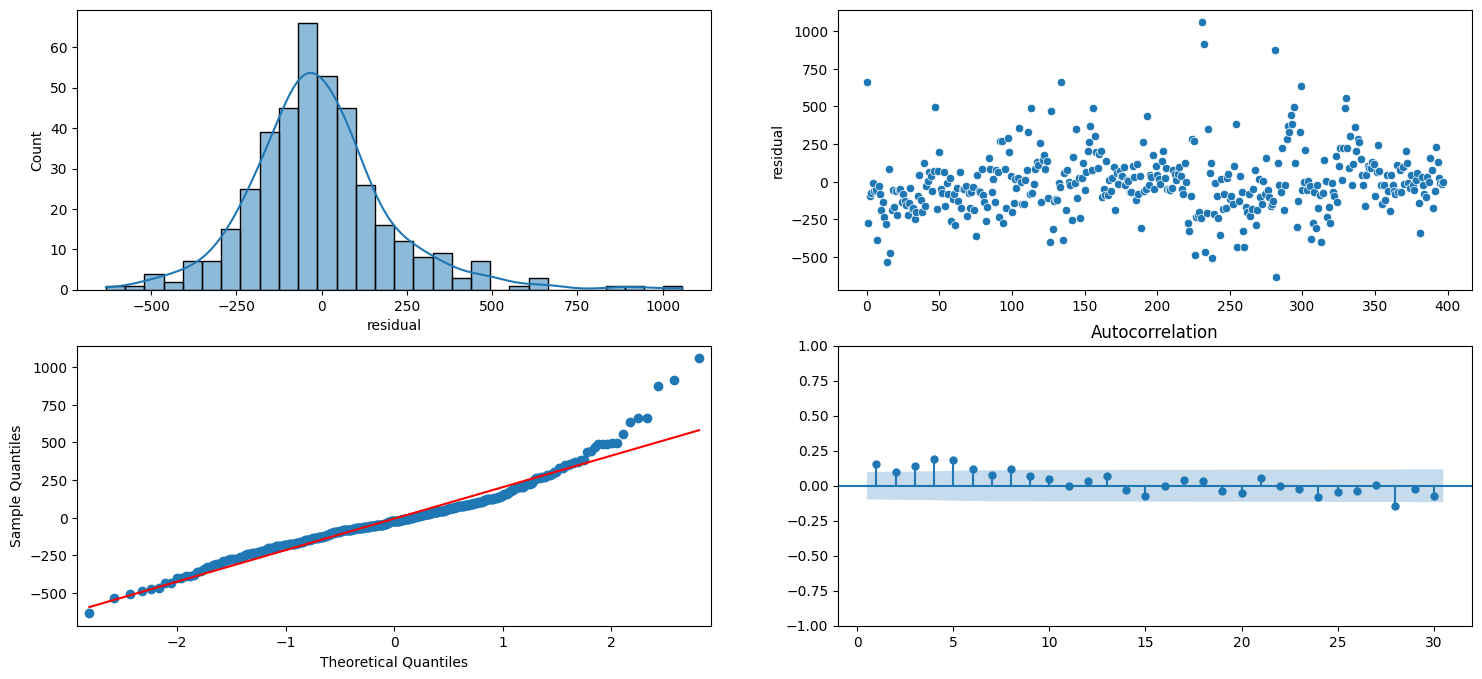

In [9]:
import seaborn as sns 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from statsmodels.graphics import tsaplots

mean, std = train_with_predicitions["residual"].mean(), train_with_predicitions["residual"].std()
print(
    f"Mean: {mean:.2f}, Std: {std:.2f}"
)
fig, axs = plt.subplots(2,2, figsize=(18,8))
sns.histplot(train_with_predicitions["residual"].to_pandas(), kde=True, ax=axs[0,0])
sns.scatterplot(train_with_predicitions["residual"].to_pandas(), ax=axs[0,1])
sm.qqplot(train_with_predicitions["residual"].to_pandas(), line="s", ax=axs[1,0])
tsaplots.plot_acf(train_with_predicitions["residual"].to_pandas(), lags=30, ax=axs[1,1], zero=False)

fig.show()


## Boostrapping Prediction Intervals

- predict value for y_t+1
- get sample for residual
- add to prediction
- repeat for B times
- get percentiles




In [10]:
import numpy as np 
residuals = train_with_predicitions["residual"].to_list()

B = 500



In [11]:
def get_bootstrap_indexes(n:int, B:int) -> np.ndarray:
    """Creates an array of Bxn where each row represent
    a random number between 0 and n. For the bootstrapp sampling,
    this means that each row is a index value to be used when sampling
    the data

    Args:
        n (int): _description_
        B (int, optional): _description_.
    """
    idx = np.random.randint(0, n, (B, n))
    return idx

In [12]:
rng = np.random.default_rng(seed=25)


bootstrap_errors = pl.DataFrame(
    rng.choice(residuals, (predictions.shape[0], B))
    , schema=[f"prediction_{x}" for x in range(B)]
)



(
    train_with_predicitions
    .select([ModelConfig.TS_INDEX, "prediction", "num_pickup"])
    .hstack(bootstrap_errors)
    .with_columns(
        [(pl.col("prediction") + pl.col(f"prediction_{x}")).alias(f"prediction_{x}") for x in range(B)]
    )
    .melt(id_vars = [ModelConfig.TS_INDEX, "prediction", "num_pickup"])
    .group_by([pl.col(ModelConfig.TS_INDEX), pl.col("prediction"), "num_pickup"])
    .agg(
        pl.col("value").quantile(0.025).alias("lower_bound")
        , pl.col("value").quantile(0.975).alias("upper_bound")
    )
    .sort(ModelConfig.TS_INDEX)
    .with_columns([
        pl.col("num_pickup").is_between(pl.col("lower_bound"), pl.col("upper_bound")).alias("in_ci")
        , (pl.col("upper_bound") - pl.col("lower_bound")).alias("width")
    ])
    .group_by(pl.col("in_ci"))
    .agg(
        pl.col("num_pickup").count()
    )
)


in_ci,num_pickup
bool,u32
false,21
true,377


In [13]:
(
    train_with_predicitions
    .with_columns(
        pl.col("num_pickup").is_between(pl.col("lower_bound"), pl.col("upper_bound")).alias("in_ci")
    )
    .group_by(pl.col("in_ci"))
    .agg(
        pl.col("num_pickup").count()
    )
)



in_ci,num_pickup
bool,u32
false,21
true,377


## Multi-step forecast

- Generate horizon and add it to dataframe
- Set dropping nulls as optional when generating the horizon
- Predict one-step ahead and add it to the dataframe



In [24]:
train.tail()

pickup_datetime_hour,pickup_location_id,num_pickup
date,i16,f64
2023-02-26,43,1271.0
2023-02-27,43,1373.0
2023-02-28,43,1563.0
2023-03-01,43,1559.0
2023-03-02,43,1713.0


In [25]:
train[ModelConfig.TS_INDEX].max() 

datetime.date(2023, 3, 2)

In [48]:
train_with_horizon

pickup_datetime_hour,pickup_location_id,num_pickup
date,i16,f64
2022-01-01,43,864.0
2022-01-02,43,991.0
2022-01-03,43,1246.0
2022-01-04,43,1334.0
2022-01-05,43,1306.0
2022-01-06,43,1474.0
2022-01-07,43,1406.0
2022-01-08,43,1440.0
2022-01-09,43,991.0


- The one-step ahead forecast is fixed and I need to calculate it first. 
- Then compute the forecast for further dates by using the previous forecast + a random sample of residuals, the lagged values are also fixed since they've been observed.
- Repeat B times
- Get percentiles

In [164]:

from datetime import timedelta
from functools import reduce


forecast_dates = [train[ModelConfig.TS_INDEX].max() + timedelta(days=x) for x in range(1,8)]

df_horizon = (
    pl.DataFrame({
        ModelConfig.TS_INDEX: pl.date_range(
        start=forecast_dates[0]
        , end=forecast_dates[-1]
        , interval="1d"
        , eager=True)
    })
    .with_columns(
        pl.lit(43).alias("pickup_location_id").cast(pl.Int16)
        , pl.lit(0).alias(ModelConfig.TARGET).cast(pl.Float64)
    )
)

train_with_horizon = (
    train
    .vstack(df_horizon)
)

forecast_df  = (
    model.predict(train_with_horizon, return_prediction_interval=False)
    .filter(pl.col(ModelConfig.TS_INDEX).is_in(forecast_dates))
    .rows()
)

forecast_dict = {x[0].strftime("%Y-%m-%d"):x[1] for x in forecast_df}


In [169]:
forecast_dates_in_str = [x.strftime("%Y-%m-%d") for x in forecast_dates]
forecast_dates_in_str


['2023-03-03',
 '2023-03-04',
 '2023-03-05',
 '2023-03-06',
 '2023-03-07',
 '2023-03-08',
 '2023-03-09']

In [171]:
B = 10
bootstrap_errors = (
    pl.DataFrame(
    rng.choice(model.named_steps["mean_predictor"].residuals, (B, len(forecast_dates)))
    , schema=[x.strftime("%Y-%m-%d") for x in forecast_dates]
    )
    .with_row_index("boostrap sample", offset=1)
    .with_columns([
        (pl.col(x) + pl.lit(forecast_dict[x])).alias(x) for x in forecast_dates_in_str
    ]
    )
)

# bootstrap_errors.with_row_index("boostrap sample", offset=1)

bootstrap_errors

boostrap sample,2023-03-03,2023-03-04,2023-03-05,2023-03-06,2023-03-07,2023-03-08,2023-03-09
u32,f64,f64,f64,f64,f64,f64,f64
1,1662.8,969.8,432.2,810.4,657.0,794.4,1321.2
2,1513.0,929.2,764.2,1210.0,997.2,837.4,1300.6
3,1445.8,1120.0,760.4,955.6,1101.2,809.4,1013.2
4,1425.2,1121.6,535.6,955.0,542.6,1173.6,922.2
5,1488.4,395.4,858.4,360.0,923.4,549.2,1100.6
6,1248.6,1330.6,842.8,1210.0,1127.4,1073.0,1245.2
7,1386.2,929.4,611.0,813.0,890.4,895.6,1065.0
8,1482.4,1130.0,783.6,786.0,806.4,1016.6,1193.6
9,1405.2,1121.4,297.4,618.6,591.2,945.4,1059.4


In [201]:
B = 1000
rng = np.random.default_rng(25)

forecast_df  = (
    model.predict(train_with_horizon, return_prediction_interval=False)
    .filter(pl.col(ModelConfig.TS_INDEX).is_in(forecast_dates))
    .rows(named=True)
    
)
CIs = [2.5, 97.5]

bootstrap_errors = (
    pl.DataFrame(
    rng.choice(model.named_steps["mean_predictor"].residuals, (B, len(forecast_dates)))
    , schema=[x.strftime("%Y-%m-%d") for x in forecast_dates]
    )
    .with_row_index("boostrap_sample", offset=0)
    .with_columns([
        (pl.col(x) + pl.lit(forecast_dict[x])).alias(x) for x in forecast_dates_in_str
    ]
    )
    .select(
        pl.col("boostrap_sample")
        , pl.cum_reduce(function=lambda acc, x: 0.25*acc + x, exprs=pl.exclude("boostrap_sample")).struct.rename_fields(forecast_dates_in_str)
    )
    .unnest("cum_reduce")
    .melt(id_vars=["boostrap_sample"], variable_name=ModelConfig.TS_INDEX)
    .group_by([pl.col(ModelConfig.TS_INDEX)])
    .agg(
        pl.col("value").mean().alias("prediction")
        , pl.col("value").quantile(CIs[0] / 100).alias("lower_bound")
        , pl.col("value").quantile(CIs[1] / 100).alias("upper_bound")
    )
    .select([pl.col(ModelConfig.TS_INDEX).str.to_date("%Y-%m-%d"), pl.col("prediction"), pl.col("lower_bound"), pl.col("upper_bound")])
    .sort(ModelConfig.TS_INDEX)
)





# forecast_df = (
#     forecast_df
#     .hstack(bootstrap_errors)
#     .with_columns(
#         [(pl.col("prediction") + pl.col(f"prediction_{x}")).alias(f"prediction_{x}") for x in range(B)]
#     )
#     .with_columns(
#         (0.25*pl.col("prediction_0").cum_sum() + 0.75*pl.col("prediction_0")).alias("pred_0")
#         , pl.col("prediction_0").cum_sum() + 0.75*pl.col("prediction_0")).alias("pred_0")
#     )
    # .with_columns(
    #     [ (pl.col(f"prediction_{x}") + 0.25*pl.col(f"prediction_{x}").shift(1, fill_value=0)).alias(f"prediction_{x}_pred") for x in range(B)]
    #     # + [ (pl.col(f"prediction_{x}").rolling(index_column=ModelConfig.TS_INDEX, period="2d")).alias(f"prediction_{x}_roll") for x in range(B)]
    #     # + [ModelConfig.TS_INDEX]
    # )
    # .melt(id_vars = [ModelConfig.TS_INDEX])
    # .group_by(pl.col(ModelConfig.TS_INDEX))
    # .agg(
    #     pl.col("value").mean().alias("prediction")
    #     , pl.col("value").quantile(0.025).alias("lower_bound")
    #     , pl.col("value").quantile(0.975).alias("upper_bound")
    # )
    # .sort(ModelConfig.TS_INDEX)
    # .with_columns(
    #     width = pl.col("upper_bound") - pl.col("lower_bound")
    # ) 
# )


bootstrap_errors.with_columns((pl.col("upper_bound") - pl.col("lower_bound")).alias("width"))



pickup_datetime_hour,prediction,lower_bound,upper_bound,width
date,f64,f64,f64,f64
2023-03-03,1512.1358,1024.0,1896.2,872.2
2023-03-04,1437.83155,942.75,1784.55,841.8
2023-03-05,1148.949087,650.5125,1560.2875,909.775
2023-03-06,1116.426072,601.9875,1523.371875,921.384375
2023-03-07,1208.186118,743.841406,1579.428125,835.586719
2023-03-08,1209.620529,716.426758,1642.167383,925.740625
2023-03-09,1354.566532,857.725293,1749.031787,891.306494


In [200]:
# plot_ts(bootstrap_errors, series=[f"prediction_{x}" for x in range(B)])

plot_ts(bootstrap_errors, series=["prediction"], fill_between=["lower_bound", "upper_bound"])
